# fastai to PyTorch to Lightning - Part 2
> A Transfer Learning Comparison

- toc: false
- branch: master
- badges: true
- comments: true
- author: Mike Fuller
- categories: [fastai, jupyter, pytorch, pytorch-lightning]
- image: images/orchid-fastai-pytorch-pl/thumbnail.png

Having been a user of fastai for a while, I figured it was time to try to learn PyTorch properly. As a learning exercise, I decided to try to recreate a fastai image classifier system using transfer learning within Pytorch and having also recently read about PyTorch Lightning, then take the PyTorch model and recreate it within Lightning. This blog series will therefore be in two parts, of which this is Part 2:

1. [fastai to PyTorch](https://mikful.github.io/blog/fastai/jupyter/pytorch/pytorch-lightning/2020/09/21/fastai-pytorch-lightning-part1.html)
2. PyTorch to PyTorch Lightning

In part 1, we saw how easy it was to achieve 98.5% accuracy on the Imagenette dataset in less than 10 minutes and 10 epochs of training using fastai, and 97.9% accuracy with a bit more work within PyTorch by trying to recreate the fastai transforms, transfer learning model and staged-training (frozen then fine-tuned). The PyTorch model also took slightly longer to train at 11.5 minutes for the 10 epochs.

# PyTorch Lightning

Now that we've trained our model with transfer learning using straight PyTorch, we'll try to repeat this using PyTorch Lighting.

A PyTorch Lightning model comprises:

1. Model
2. Optimizer
3. Data
4. Training Loop "the magic" (according to the docs!)
5. Validation Loop "the validation magic" (also according to the docs!)

However, in Lightning we define these all within the Lightning Modules, which are PyTorch `nn.Module`s but with many convenience functions and improvements.

In [ ]:
#hide
!pip install -U fastai -q
# and restart runtime
!pip install pytorch-lightning -q

import fastai
from fastai.vision.all import *
data_dir = untar_data(URLs.IMAGENETTE_160)

In [60]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.metrics import Accuracy
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import os
from pathlib import Path

## Define DataModule

The Lightning DataModule is optional but makes it easy for us to share our dataloading techniques, such as:

* Our transforms
* Our splits
* Normalization
* How the data was prepared
* Batch sizes
* DataLoaders

https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

Essential we need to create a class and give it attributes and methods for the setup we've already made in PyTorch. (In this case, I had to shuffle the validation dataset also, as otherwise all of the targets would have been `0`'s for the first batches, leading to a 0 target error.

In [61]:
class DataModule(pl.LightningDataModule):

    def __init__(self, data_dir, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transforms_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomPerspective(0.2),
            transforms.RandomResizedCrop(224, scale=(0.08, 0.75)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet stats
    ])
        
        self.transforms_val = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        

    def setup(self, stage = None):
        if stage == 'fit' or stage is None:
            self.data_train = datasets.ImageFolder(self.data_dir/"train", 
                                                   transform = self.transforms_train)
            self.data_val = datasets.ImageFolder(self.data_dir/"val", 
                                                 transform = self.transforms_val)
            
            
    def train_dataloader(self):
        return DataLoader(self.data_train, 
                          batch_size=self.batch_size, 
                          shuffle=True, # files stored by target - to avoid all targets being 0 on first batches
                          num_workers=self.num_workers,
                          pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.data_val, 
                          batch_size=self.batch_size,
                          shuffle=True, # files stored by target - to avoid all targets being 0 on first batches
                          num_workers=self.num_workers,
                          pin_memory=True)

We can now instantiate our DataModule and view the train and validation datasets as before:

In [62]:
data = DataModule(data_dir, batch_size=64, num_workers=2)
data.setup()

In [63]:
data

In [64]:
data.data_train

Dataset ImageFolder
    Number of datapoints: 9469
    Root location: /root/.fastai/data/imagenette2-160/train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomPerspective(p=0.5)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 0.75), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=None, hue=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [65]:
data.data_val

Dataset ImageFolder
    Number of datapoints: 3925
    Root location: /root/.fastai/data/imagenette2-160/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

We can also see information about the items as before:

In [66]:
data.data_train.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [67]:
num_classes = len(data.data_train.classes)
num_classes

10

In [68]:
data.batch_size

64

In [69]:
# just like before view a data input/label pair
data.data_train[1]

(tensor([[[-0.6281, -0.6281, -0.6452,  ..., -1.5870, -1.8268, -1.8268],
          [-0.6281, -0.6281, -0.6452,  ..., -1.5870, -1.8268, -1.8268],
          [-0.6281, -0.6281, -0.6452,  ..., -1.6213, -1.8439, -1.8439],
          ...,
          [-1.0733, -1.0733, -1.1075,  ...,  0.9988,  1.0331,  1.0331],
          [-1.0048, -1.0048, -1.0390,  ...,  1.0844,  1.1015,  1.1015],
          [-1.0048, -1.0048, -1.0390,  ...,  1.0844,  1.1015,  1.1015]],
 
         [[-0.4601, -0.4601, -0.4601,  ..., -1.4580, -1.6856, -1.6856],
          [-0.4601, -0.4601, -0.4601,  ..., -1.4580, -1.6856, -1.6856],
          [-0.4601, -0.4601, -0.4601,  ..., -1.4930, -1.7206, -1.7206],
          ...,
          [-1.1604, -1.1604, -1.1779,  ...,  0.6254,  0.6429,  0.6429],
          [-1.0903, -1.0903, -1.1253,  ...,  0.6954,  0.7129,  0.7129],
          [-1.0903, -1.0903, -1.1253,  ...,  0.6954,  0.7129,  0.7129]],
 
         [[-0.6541, -0.6541, -0.6541,  ..., -1.3339, -1.5779, -1.5779],
          [-0.6541, -0.6541,

In [70]:
# see total num training batches
steps_per_epoch = len(data.train_dataloader())
steps_per_epoch

148

Check a a batch of our target values:

In [71]:
inputs, targets = next(iter(data.train_dataloader()))

In [72]:
targets

tensor([0, 0, 1, 7, 6, 0, 0, 5, 3, 9, 4, 3, 3, 7, 1, 3, 1, 2, 2, 1, 0, 5, 8, 5,
        5, 4, 3, 8, 9, 9, 3, 2, 1, 8, 6, 2, 9, 6, 7, 7, 4, 5, 8, 2, 7, 7, 9, 2,
        2, 1, 0, 8, 4, 2, 1, 9, 2, 5, 6, 8, 9, 2, 0, 9])

### Visualise Batch of Images

As before, we can visualise some images:

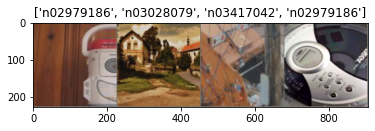

In [73]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
#     plt.figure(figsize = (20,6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data.train_dataloader()))

# Choose number items to display
n_items = 4

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:n_items])

imshow(out, title=[data.data_train.classes[x] for x in classes[:n_items]])

## Lightning Module

The main Lightning Module contains our model definition and our training loop. It also takes care of the following automatically, which greatly simplifies the training process and order of operations - saving us potential errors in the gradient accumulation or step (or lack thereof!). In addition, we can define our losses and metrics to be tracked, for printing to Tensorboard later.

* auto sets `model.train()` for Dropout or BatchNorm
* auto sets `model.eval()` for validation
* auto sets `torch.no_grad()` for logits in validation set to disable gradient accumulation
* automatically put tensors on correct devices
* automatically does `backward()` step for gradient accumulation
* track all losses and accuracies if set
* detach automatically when returning Loss
* automatic learning rate finding

Note that we do not need to change our transforms or dataloaders, as PyTorch Lighting is pure PyTorch under the hood. However, we have defined our DataModule above for reproducibility.

Note also how different optimizers and lr_schedulers have been defined based on the frozen state of the model i.e. such that we can use discriminative learning rates for different layers of the model as per fastai.

So let's define our Lightning Module. We'll first create our `AdaptiveConcatPool2D` layer as before.

In [74]:
# fastai adaptive concat pool layer
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`"
    def __init__(self, size=None):
        super(AdaptiveConcatPool2d, self).__init__()
        self.size = size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.size)
        self.mp = nn.AdaptiveMaxPool2d(self.size)
        
    def forward(self, x):
        return torch.cat([self.mp(x), self.ap(x)], 1)

Now, we put everything to do with our architecture, losses, metrics, optimizers learning rate scheduling and any other arbitrary functions, such as `freeze` and `unfreeze` functions for a staged training method using fine-tuning as we did with fastai and the PyTorch model.

In [75]:
# Take our ResNet and convert to PyTorch Lightning module
# pl.LightningModule = same as nn.Module but with added methods

class transferLearner(pl.LightningModule):
    # Define Model Architecture as before
    def __init__(self, model=None, num_classes=0, epochs=5, lr=3e-3, batch_size=64, 
                 frozen_body=False, loss_func=None, metric=None):
        super().__init__()
        
        # fastai equivalent pretrained body
        self.model_body = model
        
        # fastai equivalent head
        self.model_head = nn.Sequential(AdaptiveConcatPool2d(),
                                        nn.Flatten(),
                                        nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(p=0.25, inplace=False),
                                        nn.Linear(in_features=1024, out_features=512, bias=False),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                        nn.Dropout(p=0.5, inplace=False),
                                        nn.Linear(in_features=512, out_features=num_classes, bias=False),
                                       )
        
        self.num_classes = num_classes
        self.epochs = epochs
        self.lr=lr
        self.batch_size=batch_size
        self.frozen_body=frozen_body
        self.loss_func=loss_func
        self.metric=metric
            
    # define our forward loop as before
    def forward(self, x, *args, **kwargs):
        out = self.model_body(x)
        out = self.model_head(out)
        return out

    
    # Define our freeze and unfreeze functions as before
    def freeze(self):
        for name, param in self.model_body.named_parameters():
            if("bn" not in name):
                param.requires_grad = False
                # print(f'{name} requires_grad state: {param.requires_grad}') 
        self.frozen_body = True
        print(f'Model frozen: {self.frozen_body}')
        print(f'{sum(p.numel() for p in self.parameters() if p.requires_grad)} trainable parameters.')

    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True

        self.frozen_body = False
        print(f'Model frozen: {self.frozen_body}')
        print(f'{sum(p.numel() for p in self.parameters() if p.requires_grad)} trainable parameters.')
    
    
    # Define configure_optimizers method by depending on model's frozen state (i.e. head training / fine-tune)
    # fine-tune: pass network's body and head parameters separately for both optimizer and lr scheduler
    # and discriminative layer lr_scheduling
    def configure_optimizers(self):
        
        if self.frozen_body:
            optimizer = optim.Adam(self.parameters(), lr=self.lr)
                
            lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,                           
                max_lr=self.lr, # single max_lr based on learning rate finder
                total_steps= self.epochs * steps_per_epoch,
                epochs=self.epochs
            )
            scheduler = {"scheduler": lr_scheduler, "interval" : "step" } # to step at each batch rather than each epoch for 1cycle learning rates      
        
        elif self.frozen_body == False:
            optimizer = optim.Adam([{"params": self.model_body.parameters(), "lr": self.lr}, 
                                    {"params": self.model_head.parameters(), "lr": self.lr}])
            
            lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,                           
                max_lr=[self.lr/100, self.lr], # grouped max_lr's for body and head
                total_steps= self.epochs * steps_per_epoch,
                epochs=self.epochs
            )
            scheduler = {"scheduler": lr_scheduler, "interval": "step" } # to step at each batch rather than each epoch for 1cycle learning rates
        
        return [optimizer], [scheduler]
    
    # Print new progress bar each epoch
    def on_epoch_start(self):
        print('\n')
    
    # Define training_step training loop method
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        result = pl.TrainResult(loss)
        result.log('train_loss:', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return result
    
    # Create a validation_step hook by calling the training_step method
    # i.e. for batch return the loss and acc and cache it
    # returned to validation_epoch_end
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        acc = self.metric(y_hat, y)
        result = pl.EvalResult()
        result.valid_batch_loss = loss
        result.valid_batch_acc = acc
        result.log('valid_loss:', loss, on_epoch=True, prog_bar=True, logger=True)
        return result

    # Get our average loss and accuracy
    def validation_epoch_end(self, outputs):
        avg_loss = outputs.valid_batch_loss.mean()
        avg_acc = outputs.valid_batch_acc.mean()
        result = pl.EvalResult(checkpoint_on=avg_loss)
        result.log_dict({'val_loss': avg_loss, 'val_acc': avg_acc}, on_epoch=True, prog_bar=True)
        return result

In [76]:
# create our the body of our model by cutting pretrained network
def create_model_body(model, cut=-2):
    model_body_modules = list(model.children())[:cut]
    return nn.Sequential(*model_body_modules)

model_body = create_model_body(model=torchvision.models.resnet18(pretrained=True))

## Train our model

Again let's try 5 epochs frozen and 5 unfrozen fine-tuned.

We'll set a seed for reproducibility:

In [77]:
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateLogger

# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
seed_everything(42)

# Create our hyperparameters and instantiate model
batch_size = 64

data = DataModule(data_dir, batch_size=batch_size, num_workers=8)

model = transferLearner(model=model_body, num_classes=num_classes, epochs=5, 
                        lr=3e-3, batch_size=batch_size, frozen_body=True, 
                        loss_func=nn.CrossEntropyLoss(), metric=Accuracy())

Let's ensure all the body parameters are frozen such that it's a fixed-feature extractor tp traom tje custom head initially:

In [78]:
model.freeze()

Model frozen: True
540160 trainable parameters.


Now let's find our learning rate with the lr finder, just as we did with fastai.

Note: This is for the frozen pretrained network and unfrozen custom head as `self.frozen_body = True`

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | model_body | Sequential       | 11 M  
1 | model_head | Sequential       | 532 K 
2 | loss_func  | CrossEntropyLoss | 0     
3 | metric     | Accuracy         | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


0.0009120108393559097


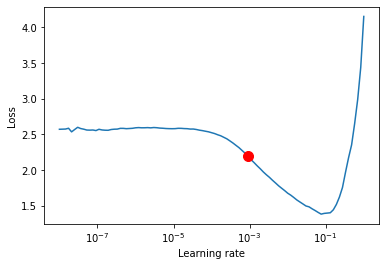

In [79]:
# # Define Trainer (with deterministic seeds for reproducibility)
trainer = Trainer(gpus=1, deterministic=True)

# Run learning rate finder on our data
lr_finder = trainer.lr_find(model, data)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
suggested_lr = lr_finder.suggestion()
print(suggested_lr)

In this case, we already knew our learning rate would be 3e-3 as per fastai, but it's good to see the lr_finder matches.

Now let's train our custom head and monitor the learning rate, such that we can check it is cycling correctly in the tensorboard. We also turn `auto_lr_find=False` as this is called automatically during the initial training otherwise, whereas we want to set our learning rate manually to the same as the fastai and PyTorch models for a direct comparison.

In [80]:
# Fit model
lr_monitor = LearningRateLogger(logging_interval='step')
trainer = Trainer(gpus=1, 
                  max_epochs=model.epochs, 
                  deterministic=True, 
                  callbacks=[lr_monitor],
                  auto_lr_find=False)
trainer.fit(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name       | Type             | Params
------------------------------------------------
0 | model_body | Sequential       | 11 M  
1 | model_head | Sequential       | 532 K 
2 | loss_func  | CrossEntropyLoss | 0     
3 | metric     | Accuracy         | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

Now unfreeze, find the new maximum learning rate (for discriminative layer rates in transferNet) and train further:

In [81]:
model.unfreeze()

Model frozen: False
11708992 trainable parameters.


Note: this time note discriminative learning rates are being using within the transferNet lr_scheduler due to `model_frozen = False` and `model.unfreeze()`

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | model_body | Sequential       | 11 M  
1 | model_head | Sequential       | 532 K 
2 | loss_func  | CrossEntropyLoss | 0     
3 | metric     | Accuracy         | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..
LR finder stopped early due to diverging loss.


5.75439937337157e-07


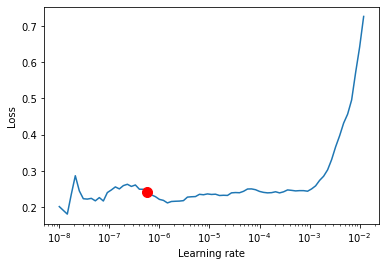

In [82]:
# Define Trainer (with deterministic seeds for reproducibility)
trainer = Trainer(gpus=1, deterministic=True)

# Run learning rate finder on our data
lr_finder = trainer.lr_find(model,data)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
suggested_lr = lr_finder.suggestion()
print(suggested_lr)

In this case, I had set the discrminative learning rate parameter directly within the Lightning Module above, such that the learning rate for the pretrained body was the custom head learning rate / 100. So now we'll set the main learning rate.

In [83]:
# update the hparam.learning_rate choice
model.lr = 3e-4

In [ ]:
# Fit model again
lr_monitor = LearningRateLogger(logging_interval='step')
trainer = Trainer(gpus=1, max_epochs=5, deterministic=True, callbacks=[lr_monitor], auto_lr_find=False)
trainer.fit(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name       | Type             | Params
------------------------------------------------
0 | model_body | Sequential       | 11 M  
1 | model_head | Sequential       | 532 K 
2 | loss_func  | CrossEntropyLoss | 0     
3 | metric     | Accuracy         | 0     
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

We can see from the tensorboard output that the learning rates were cycling correctly. Initially with a single maximum learning rate for the custom head training and then within two parameter groups (pg1 / pg2) for the discriminative layer learning rates in the second fine-tuning stage. We can also see our final validation accuracy.

![pytorch-lightning-tboard](../images/fastai-pytorch-pl/pl-tensorboard.png)

## Results

Using PyTorch Lightning we've acheived a final validation accuracy of: 98.0% (in just over 10 mins) essentially equaling the PyTorch performance as it should (being the same code under the hood), although it seemed to train slightly faster.

# Final Results

So let's look at the final results:

* fastai - 98.5%
* PyTorch Lightning - 98.0%
* PyTorch - 97.9%


So with fastai we acheived the highest validation accuracy, of a 0.6% / 0.5% improvement above the PyTorch and Lighting implementations, but in a much more straightforward manner. In addition, due to the GPU batch transforms it trained much faster. 

# Conclusion

Clearly, fastai has the edge in terms of speed and ease of training a state-of-the-art image classification model, which likely holds true for tasks in all of the standard pipelines it provides (Image Classification, Text, Collaborative Filtering, Tabular Data). However, for more unorthdox pipelines, or investigation into new architectures and methods of training, PyTorch Lightning clearly has the edge over both fastai and PyTorch (although the fastai version 2 API makes this much more straightforward) and I will definitely be using it for any personal research in the future. The benefits for me are as follows:

* Greatly simplifies the training and validation loop over pure PyTorch
* Has great features such as the learning rate finder, Tensorboard integration
* Clear PyTorch syntax makes it far easier to get under-the-hood than fastaiand and more understandable in terms of the implementation details

This has been a really useful learning exercise for me and I'm sure I've only just scratched the surface of using PyTorch and PyTorch Lightning, so hopefully will be making more posts using them soon. 

I hope this was informative, if you have any queries or comments, I would love to hear them, so please do let me know. 